<a href="https://colab.research.google.com/github/xavienzo/ICONS/blob/demo/GPLS692.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install packages
install.packages("igraph")
install.packages("WGCNA")
devtools::install_github("xavienzo/ICONS")

# Load packages
library(ICONS)
library(igraph)
library(WGCNA)
library(tidyverse)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'ICONS' from a github remote, the SHA1 (ffdc4fe0) has not changed since last install.
  Use `force = TRUE` to force installation


Attaching package: ‘igraph’


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




# **ADNI DNA methylation data**


*   [ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/)
  - ADNI is a large, longitudinal, multi-center study designed to develop clinical, imaging, genetic, and biochemical biomarkers for the early detection and tracking of Alzheimer’s disease (AD)
*   Sample size n=366
*   4200 AD-related CpG sites





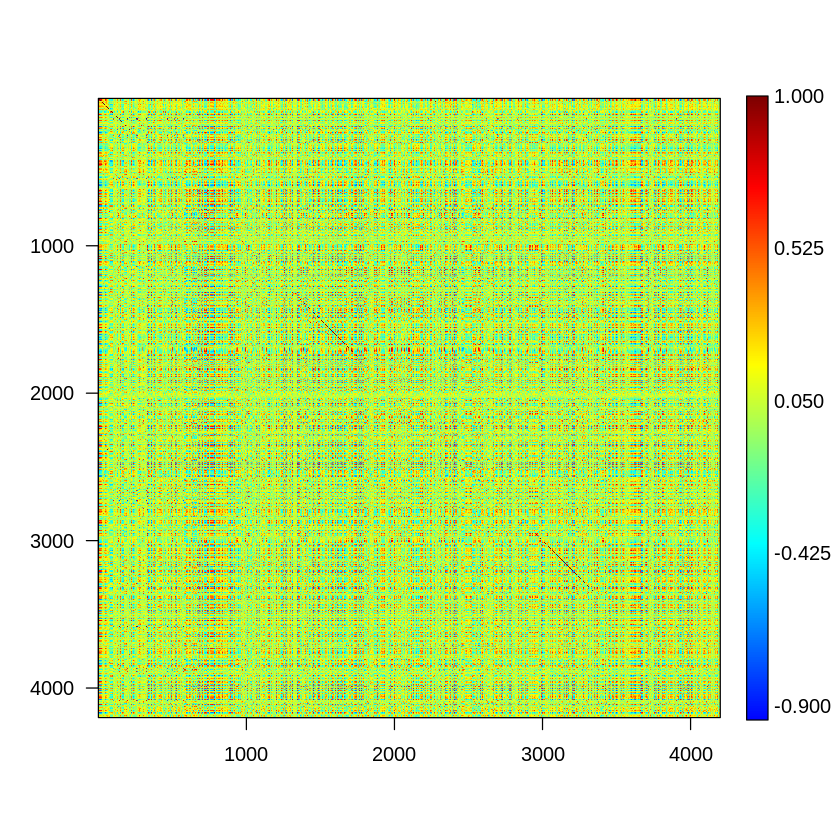

In [ ]:
adni <- readRDS("/ADNImethyl_dat.Rds")
adni <- do.call(rbind, adni)
adni <- t(adni)
adni_cor <- cor(adni)

# plot original correlation matrix
plotMatrix(adni_cor)

## [**WGCNA**](https://doi.org/10.1186/1471-2105-9-559)

- Primarily used in genomics for constructing networks based on gene expression data and identifying modules of co-expressed genes.
- Issues with high dimensionality of parameter space:
  - WGCNA involves selecting multiple parameters, such as the soft-thresholding power, the module size, and the merging threshold for similar modules.
  - Difficult to find the optimal combination of parameters.

Reference

Langfelder, P., Horvath, S. WGCNA: an R package for weighted correlation network analysis. BMC Bioinformatics 9, 559 (2008).

R Tutorial: https://bioinformaticsworkbook.org/tutorials/wgcna.html#gsc.tab=0


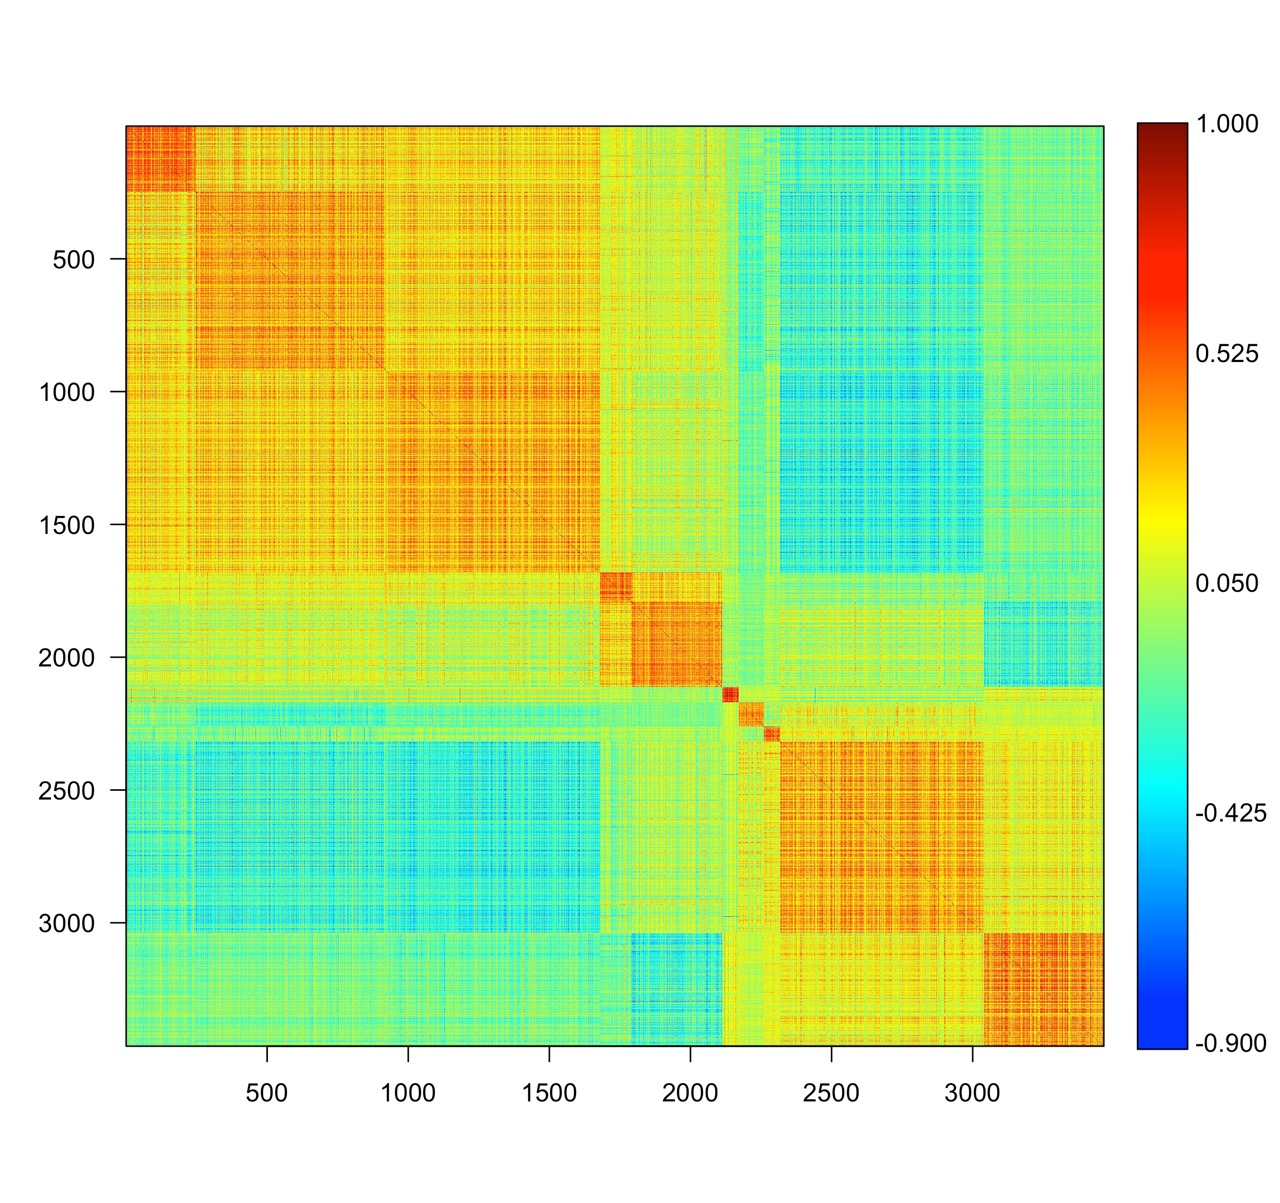

## [**LOUVAIN**](https://doi.org/10.1088/1742-5468/2008/10/P10008)
Blondel, V. D., Guillaume, J.-L., Lambiotte, R. & Lefebvre, E. Fast unfolding of communities in large networks. J. Stat. Mech. Theory Exp. 10008, 6 (2008).

- One of the fastest and best performing algorithms in comparative analyses (Lancichinetti 2009; Yang 2016), and one of the most-cited works in the community detection literature.
- Maximize **modularity**, which is the difference between the actual number of edges in a community and the number of such edges expected in a random graph.

Figure from https://www.nature.com/articles/s41598-019-41695-z
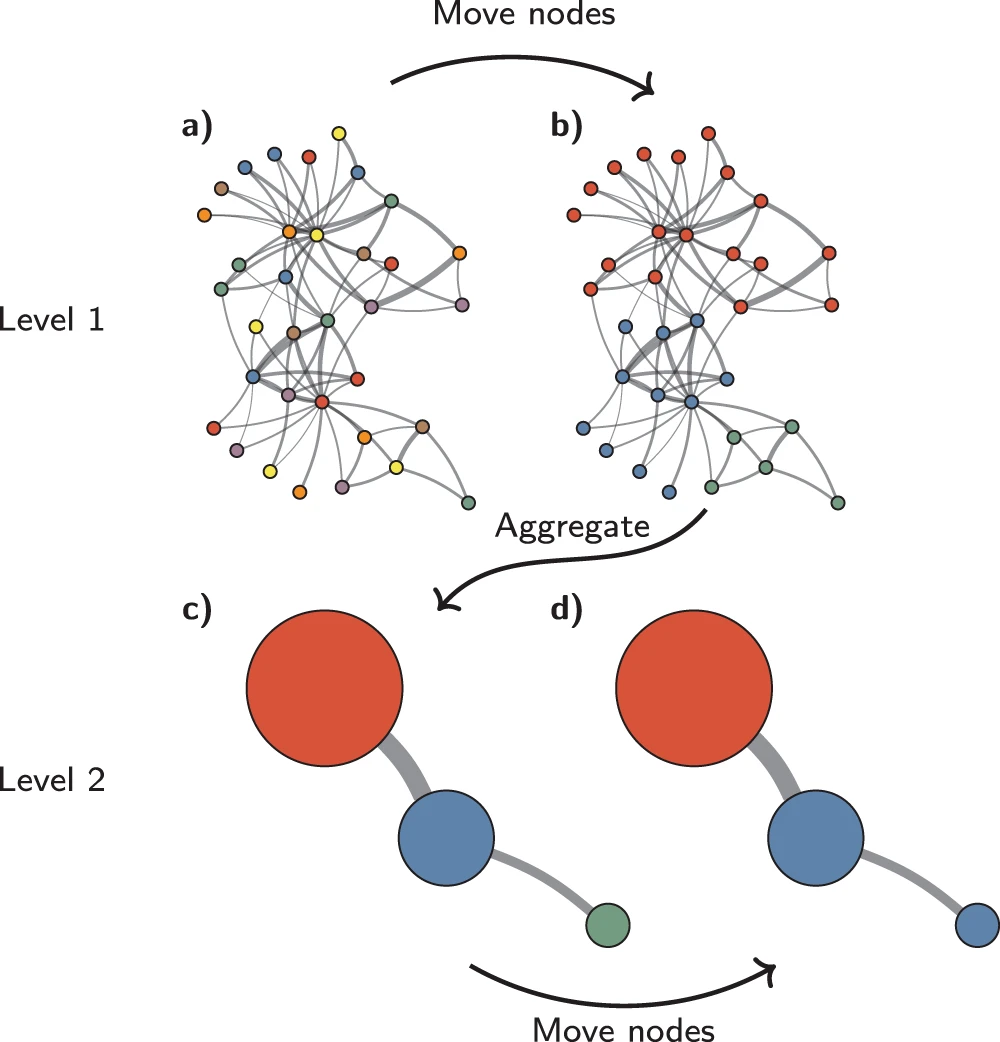
- Issues with resolution limit: unable to detect small communities in a network if these communities are below a certain size threshold, even if they are well-defined and densely connected (Fortunato 2007).
- It was recently suggested that the Louvain algorithm has a major problem in terms of modularity and other network quality measures. Louvain may yield arbitrarily badly connected communities, over and above the well-known issue of the resolution limit (Traag 2019).



In [22]:
# Step 1: Set up graph model
cor_matrix <- abs(adni_cor)
G <- graph_from_adjacency_matrix(cor_matrix,
                                 weighted = T,
                                 mode = "undirected")

# Step 2: Apply the Louvain algorithm to detect communities
louvain_result <- cluster_louvain(G)

# Step 3: Extract communities and map them back to variables
communities <- louvain_result$membership
adni_cor_louvain <- adni_cor[order(communities), order(communities)]

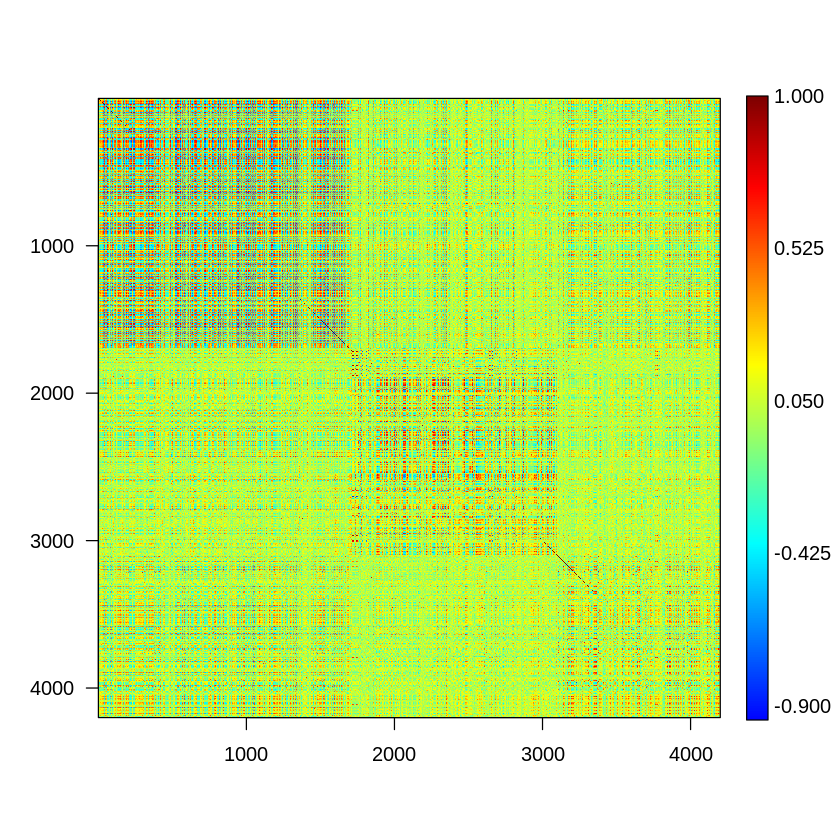

In [23]:
# Plot the correlation matrix rearranged in Louvain community order
plotMatrix(adni_cor_louvain)

In [25]:
CID_l <- as.numeric(table(factor(communities, levels = unique(communities))))
Clist_l <- order(communities)
get_sigmau(adni, CID_l, Clist_l)[[2]]

[1] 2.00295

## [**Greedy peeling**](https://doi.org/10.1088/1742-5468/2008/10/P10008)
Clauset, A., Newman, M. E. J. & Moore, C. Finding community structure in very large networks. Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 70, (2004).

- A heuristic algorithm commonly used in graph mining, particularly in areas like social network analysis, protein and gene analyses.
- Starts with the entire graph and progressively removes nodes based on a specific criterion, typically related to node connectivity.
- Fast and simple, but prone to suboptimal solutions.
- Focuses on isolating a single dense subgraph; may not perform well when there are multiple dense regions.

In [26]:
# Apply the greedy peeling algorithm
greedy_result <- cluster_fast_greedy(G)
communities <- greedy_result$membership
adni_cor_greedy <- adni_cor[order(communities), order(communities)]

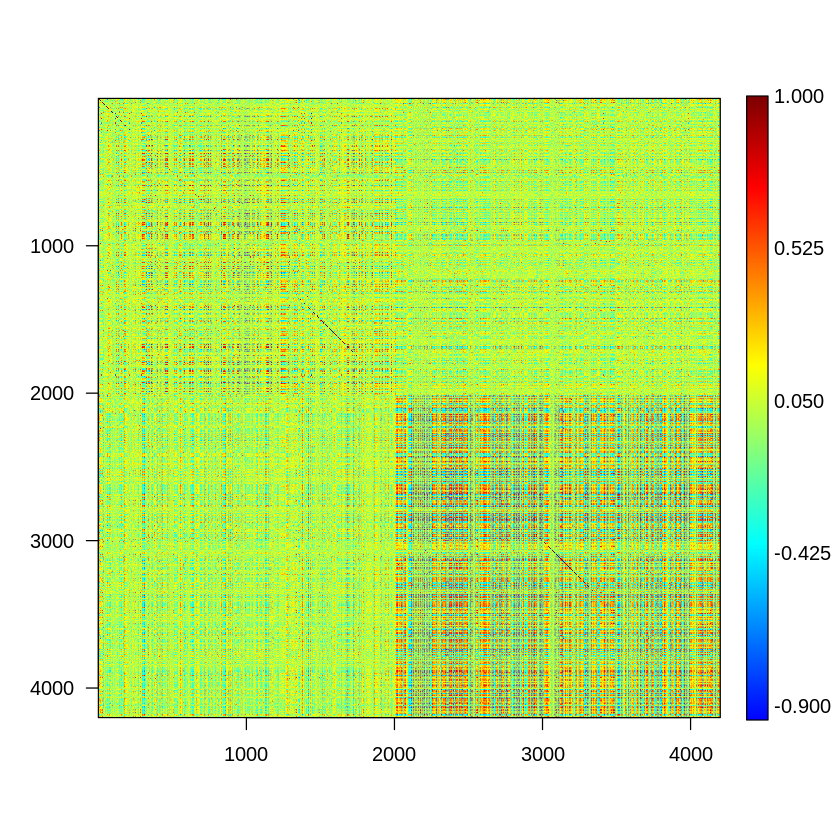

In [15]:
# Plot the correlation matrix rearranged in greedy peeling community order
plotMatrix(adni_cor_greedy)

In [27]:
CID_g <- as.numeric(table(factor(communities, levels = unique(communities))))
Clist_g <- order(communities)
get_sigmau(adni, CID_g, Clist_g)[[2]]

[1] 2.00324

## [**ICONS**](https://github.com/xavienzo/ICONS)

*   Integrative analysis of COvariance matrix and Network Structure
*   A novel adaptive subnetwork extraction tool

Reference
- Wu, Q. et al. Extracting brain disease-related connectome subgraphs by adaptive dense subgraph discovery. Biometrics 78, 1566–1578 (2021).
- Chen, S. et al. Identifying covariate-related subnetworks for whole-brain connectome analysis. Biostatistics 25, 541–558 (2024).



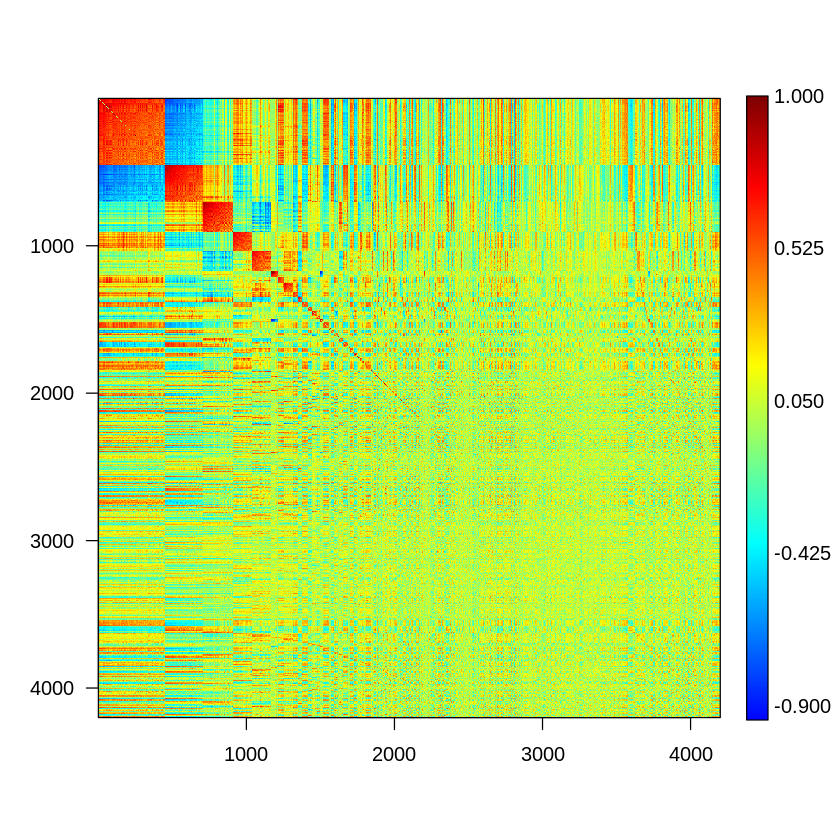

In [20]:
## network extraction using our tool

# Set up the parameter grid for parameter tuning
prctile_vec <- seq(94, 99, by = 0.5)
lambda_vec <- seq(0.5, 0.8, length.out = 4)

# Parameter tuning
res <- param_tuning_sigmau(adni_cor, adni, prctile_vec, lambda_vec)

# Dense subnetwork extraction
results <- dense(adni_cor, res$cut_out, res$lambda_out)

# Plot the reordered correlation matrix showing network structures
plotMatrix(results$W_dense)

In [28]:
get_sigmau(adni, results$CID, results$Clist)[[2]]

[1] 1.491862

In [29]:
## perform Semi-confirmatory factor analysis
fa <- scfa(adni, results$CID, results$Clist)
# factor loadings
fa$loading
# factor scores
fa$factorscore

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
 [1,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [2,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [3,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [4,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [5,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [6,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [7,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [8,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
 [9,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[10,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[11,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[12,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[13,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[14,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[15,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[16,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[17,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[18,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[19,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[20,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[21,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[22,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[23,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[24,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[25,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[26,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[27,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[28,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[29,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[30,] 1    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[31,] ⋮    ⋮    ⋮    ⋮    ⋮    ⋮    ⋮    ⋮    ⋮    ⋮     ⋱     ⋮     ⋮    
[32,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[33,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[34,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[35,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[36,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[37,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[38,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[39,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[40,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[41,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[42,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[43,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[44,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[45,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[46,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[47,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[48,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[49,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[50,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[51,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[52,] 0    0    0    0    0    0    0    0    0    0     ⋯     0     0    
[53,] 0    0    0    0    0    

200223270003_R03C01 200223270003_R05C01 200223270003_R06C01
 [1,] -0.001370813         0.0048239639       -0.0020314883      
 [2,] -0.001793077        -0.0094702849        0.0012107599      
 [3,] -0.049071365        -0.0612250839        0.0172343943      
 [4,] -0.010533629        -0.0076861824       -0.0049690548      
 [5,]  0.035723310         0.0248557376       -0.0020826966      
 [6,]  0.140117107        -0.1172887708        0.1577705043      
 [7,]  0.012940598        -0.0027212178        0.0017268658      
 [8,]  0.007337024        -0.0028527650       -0.0044795087      
 [9,]  0.015591721         0.0132024163       -0.0082800408      
[10,] -0.009597289        -0.0143052197        0.0115114042      
[11,]  0.001089853        -0.0016803648       -0.0008760228      
[12,]  0.001040115        -0.0004146361        0.0008444861      
[13,]  0.001577963         0.0036786369        0.0043228255      
[14,]  0.004732854         0.0051408583        0.0103074017      
[15,] -0.060199958         0.0651817966       -0.0898846444      
[16,] -0.036463323        -0.0095009597       -0.0280675078      
[17,]  0.002017765        -0.0032094525       -0.0060016324      
[18,]  0.010222723        -0.0047064119        0.0019392089      
[19,]  0.011299028        -0.0034039283        0.0015067753      
[20,] -0.002090697        -0.0007294483       -0.0055715995      
[21,] -0.044723754        -0.0346854363        0.0158694583      
[22,]  0.017275722        -0.0273195523       -0.0066560425      
[23,] -0.004819583        -0.0063049329       -0.0056578815      
[24,]  0.020293023         0.0131474523        0.0054194073      
[25,] -0.043359115        -0.0170436359       -0.0399031648      
[26,] -0.002484522        -0.0021347588       -0.0015142646      
[27,] -0.006841762        -0.0541558886       -0.0089060090      
[28,]  0.049310875         0.0213438517       -0.0103133779      
[29,] -0.013081222        -0.0014696420       -0.0045303839      
[30,]  0.012691738         0.0239221017        0.0109341486      
[31,] ⋮                   ⋮                   ⋮                  
[32,] -0.0056236128       -0.0032284913       -0.0054991616      
[33,]  0.0445053329       -0.0101865954        0.0276051809      
[34,]  0.0055229466       -0.0225984765        0.0293634752      
[35,]  0.0352692794        0.0144066990        0.0159054991      
[36,] -0.1002891089        0.0233496279        0.0285736817      
[37,]  0.0583858541       -0.0603666282        0.0707249635      
[38,]  0.0007581708       -0.0092877860        0.0038671546      
[39,] -0.0552974590       -0.0927841755        0.0766749296      
[40,] -0.0011251597       -0.0094328047       -0.0036863314      
[41,] -0.0054798483       -0.0126202081        0.0259061997      
[42,]  0.0051733951       -0.0009950770        0.0172866910      
[43,]  0.0317649021       -0.0003089417        0.0296885151      
[44,]  0.0126571795        0.0348744564        0.0264876790      
[45,] -0.0012246424        0.0057490852       -0.0024785419      
[46,]  0.0107221751       -0.0085819380       -0.0119971739      
[47,]  0.0178348031       -0.0032600375        0.0103306088      
[48,]  0.0052852853       -0.0048041220       -0.0090395944      
[49,]  0.0169680796        0.0056183314        0.0410777797      
[50,] -0.0044346250        0.0016992293        0.0009231951      
[51,]  0.0255318780        0.0041452160       -0.0120697596      
[52,]  0.0271454998       -0.0223949616        0.0185443360      
[53,] -0.0487356286       -0.0313239254        0.0198415828      
[54,] -0.0127071463       -0.0239166700       -0.0117894793      
[55,] -0.0013995248        0.0004296502       -0.0110755936      
[56,]  0.0795967573        0.0249610255        0.0357227473      
[57,] -0.0082201587       -0.0058067319       -0.0178359102      
[58,] -0.0037732170       -0.0002991005        0.0026538838      
[59,]  0.0051105085       -0.0035050224       -0.0026135809      
[60,] -0.0586190392        0.0008655400       

# **Simulated dataset**

1. Define a population covariance matrix

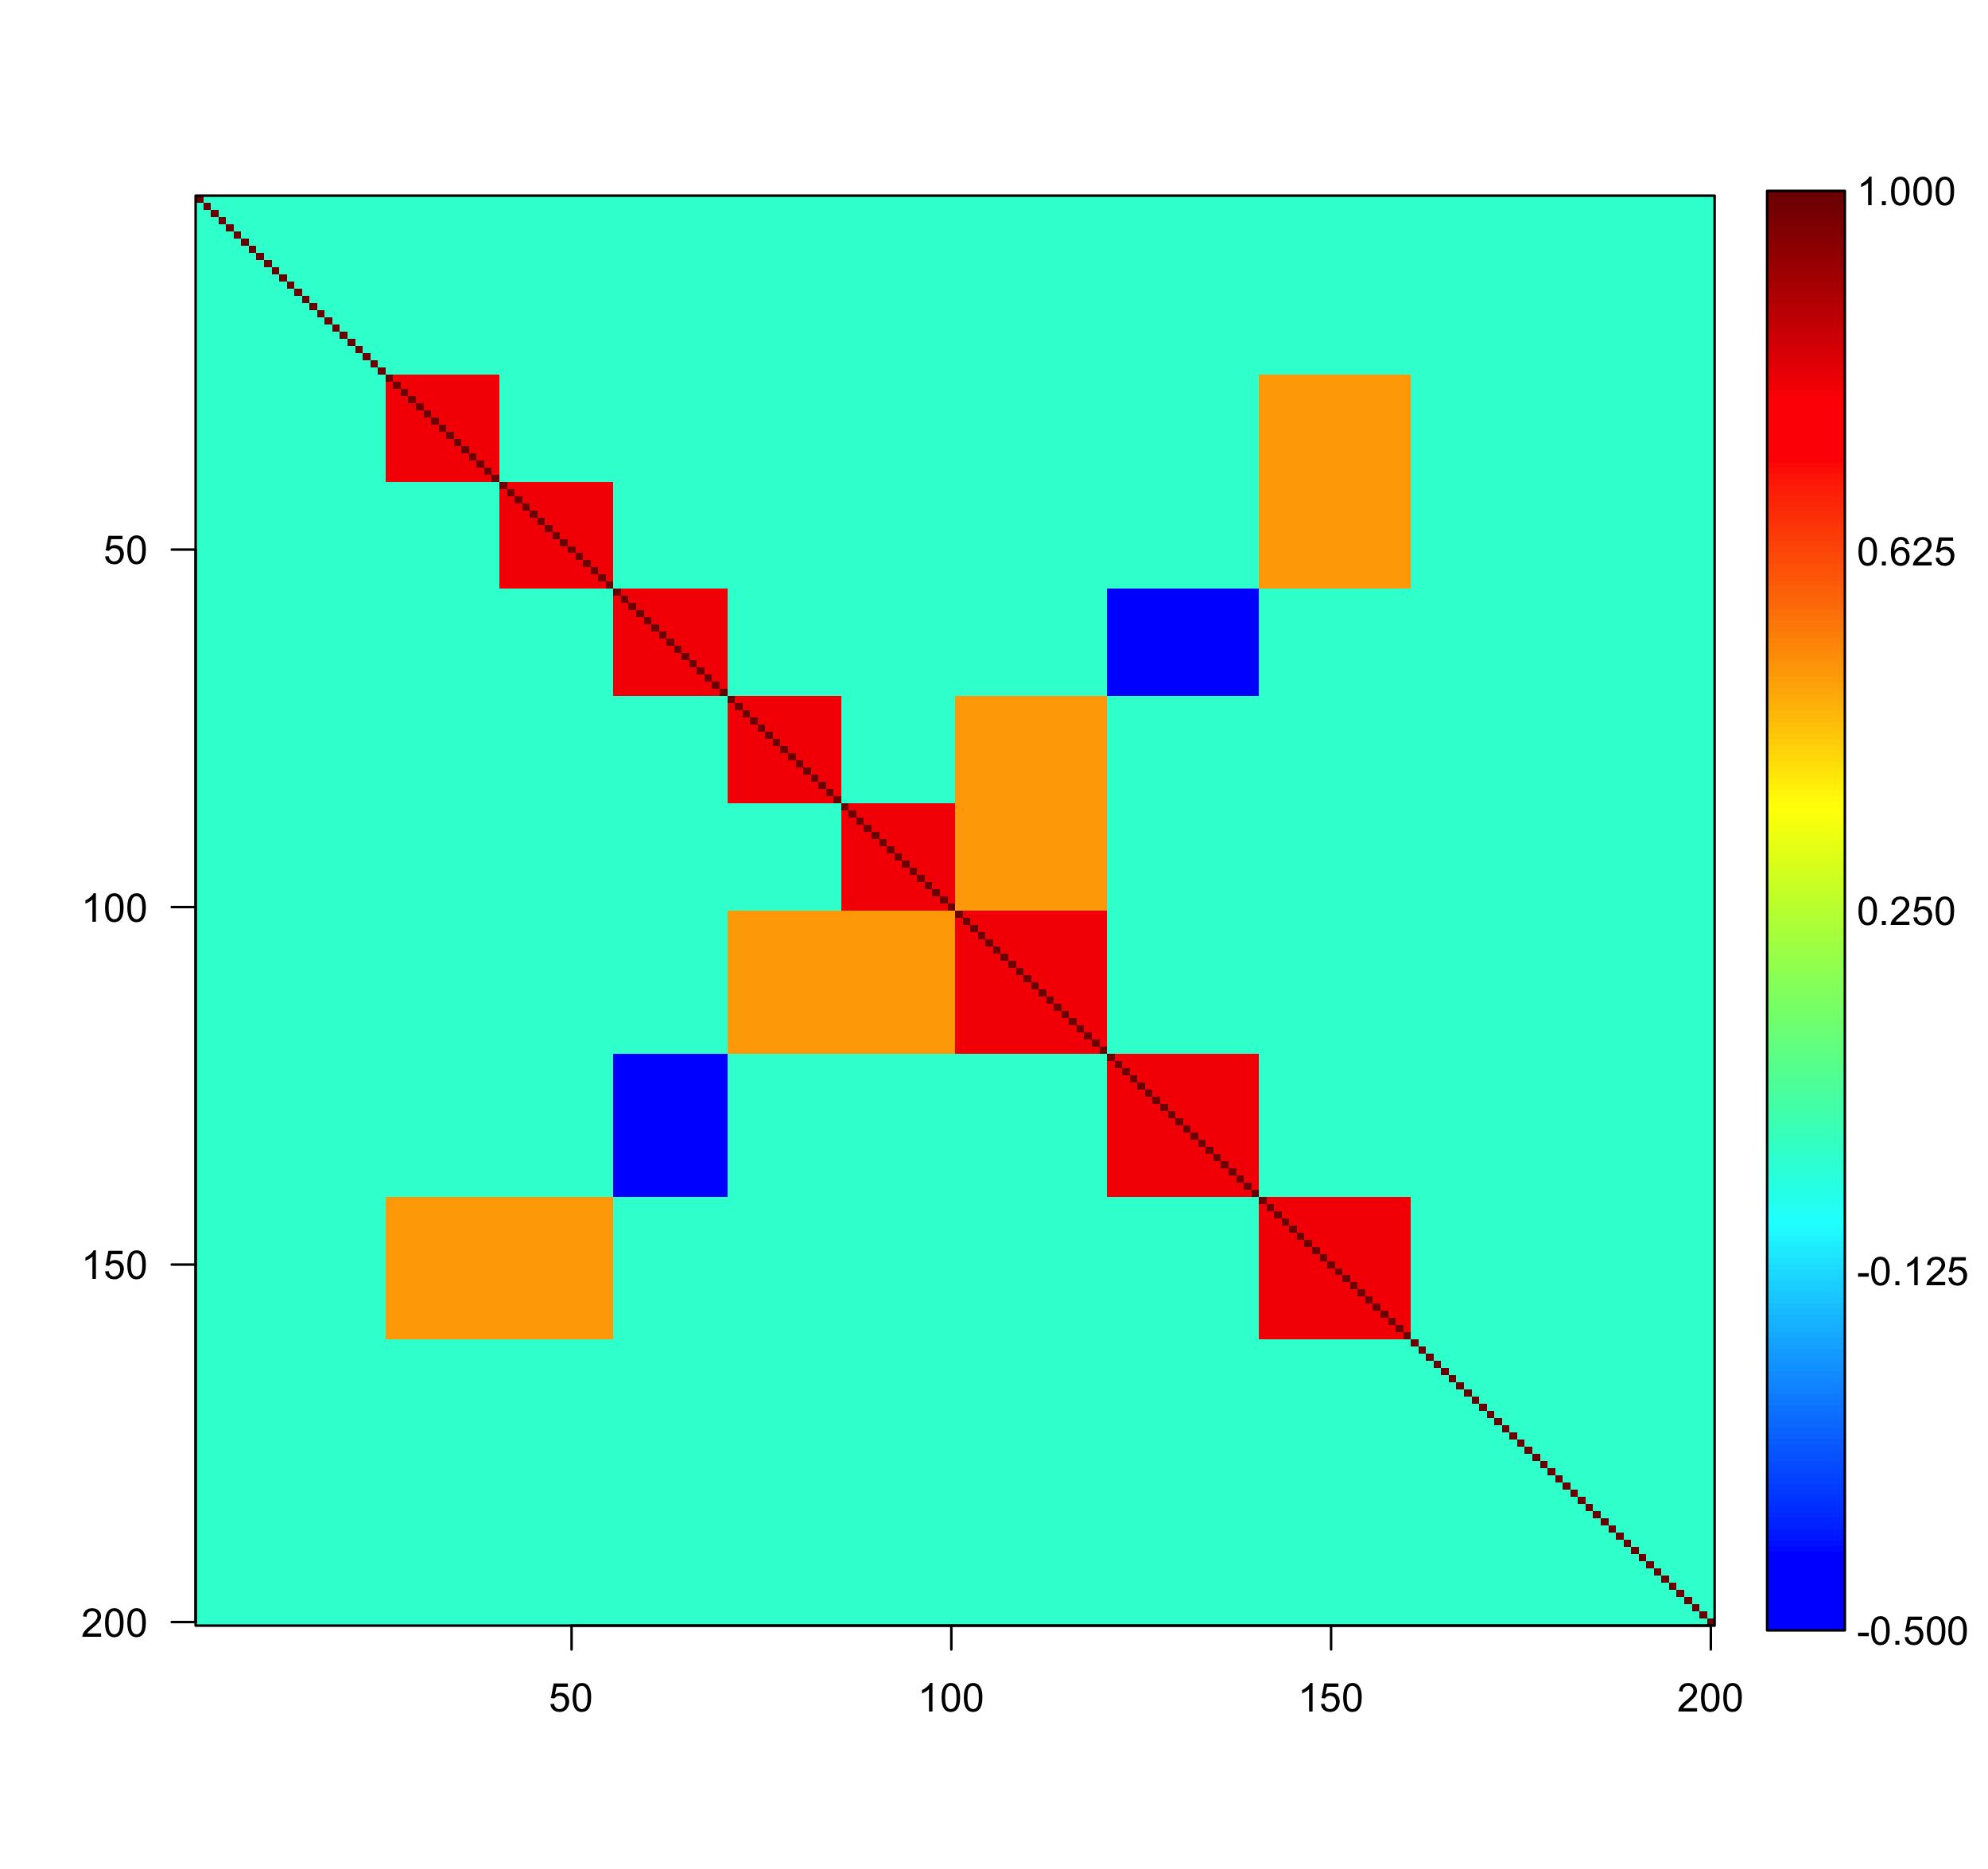


2.Use Cholesky decomposition to generate samples from a multivariate normal distribution
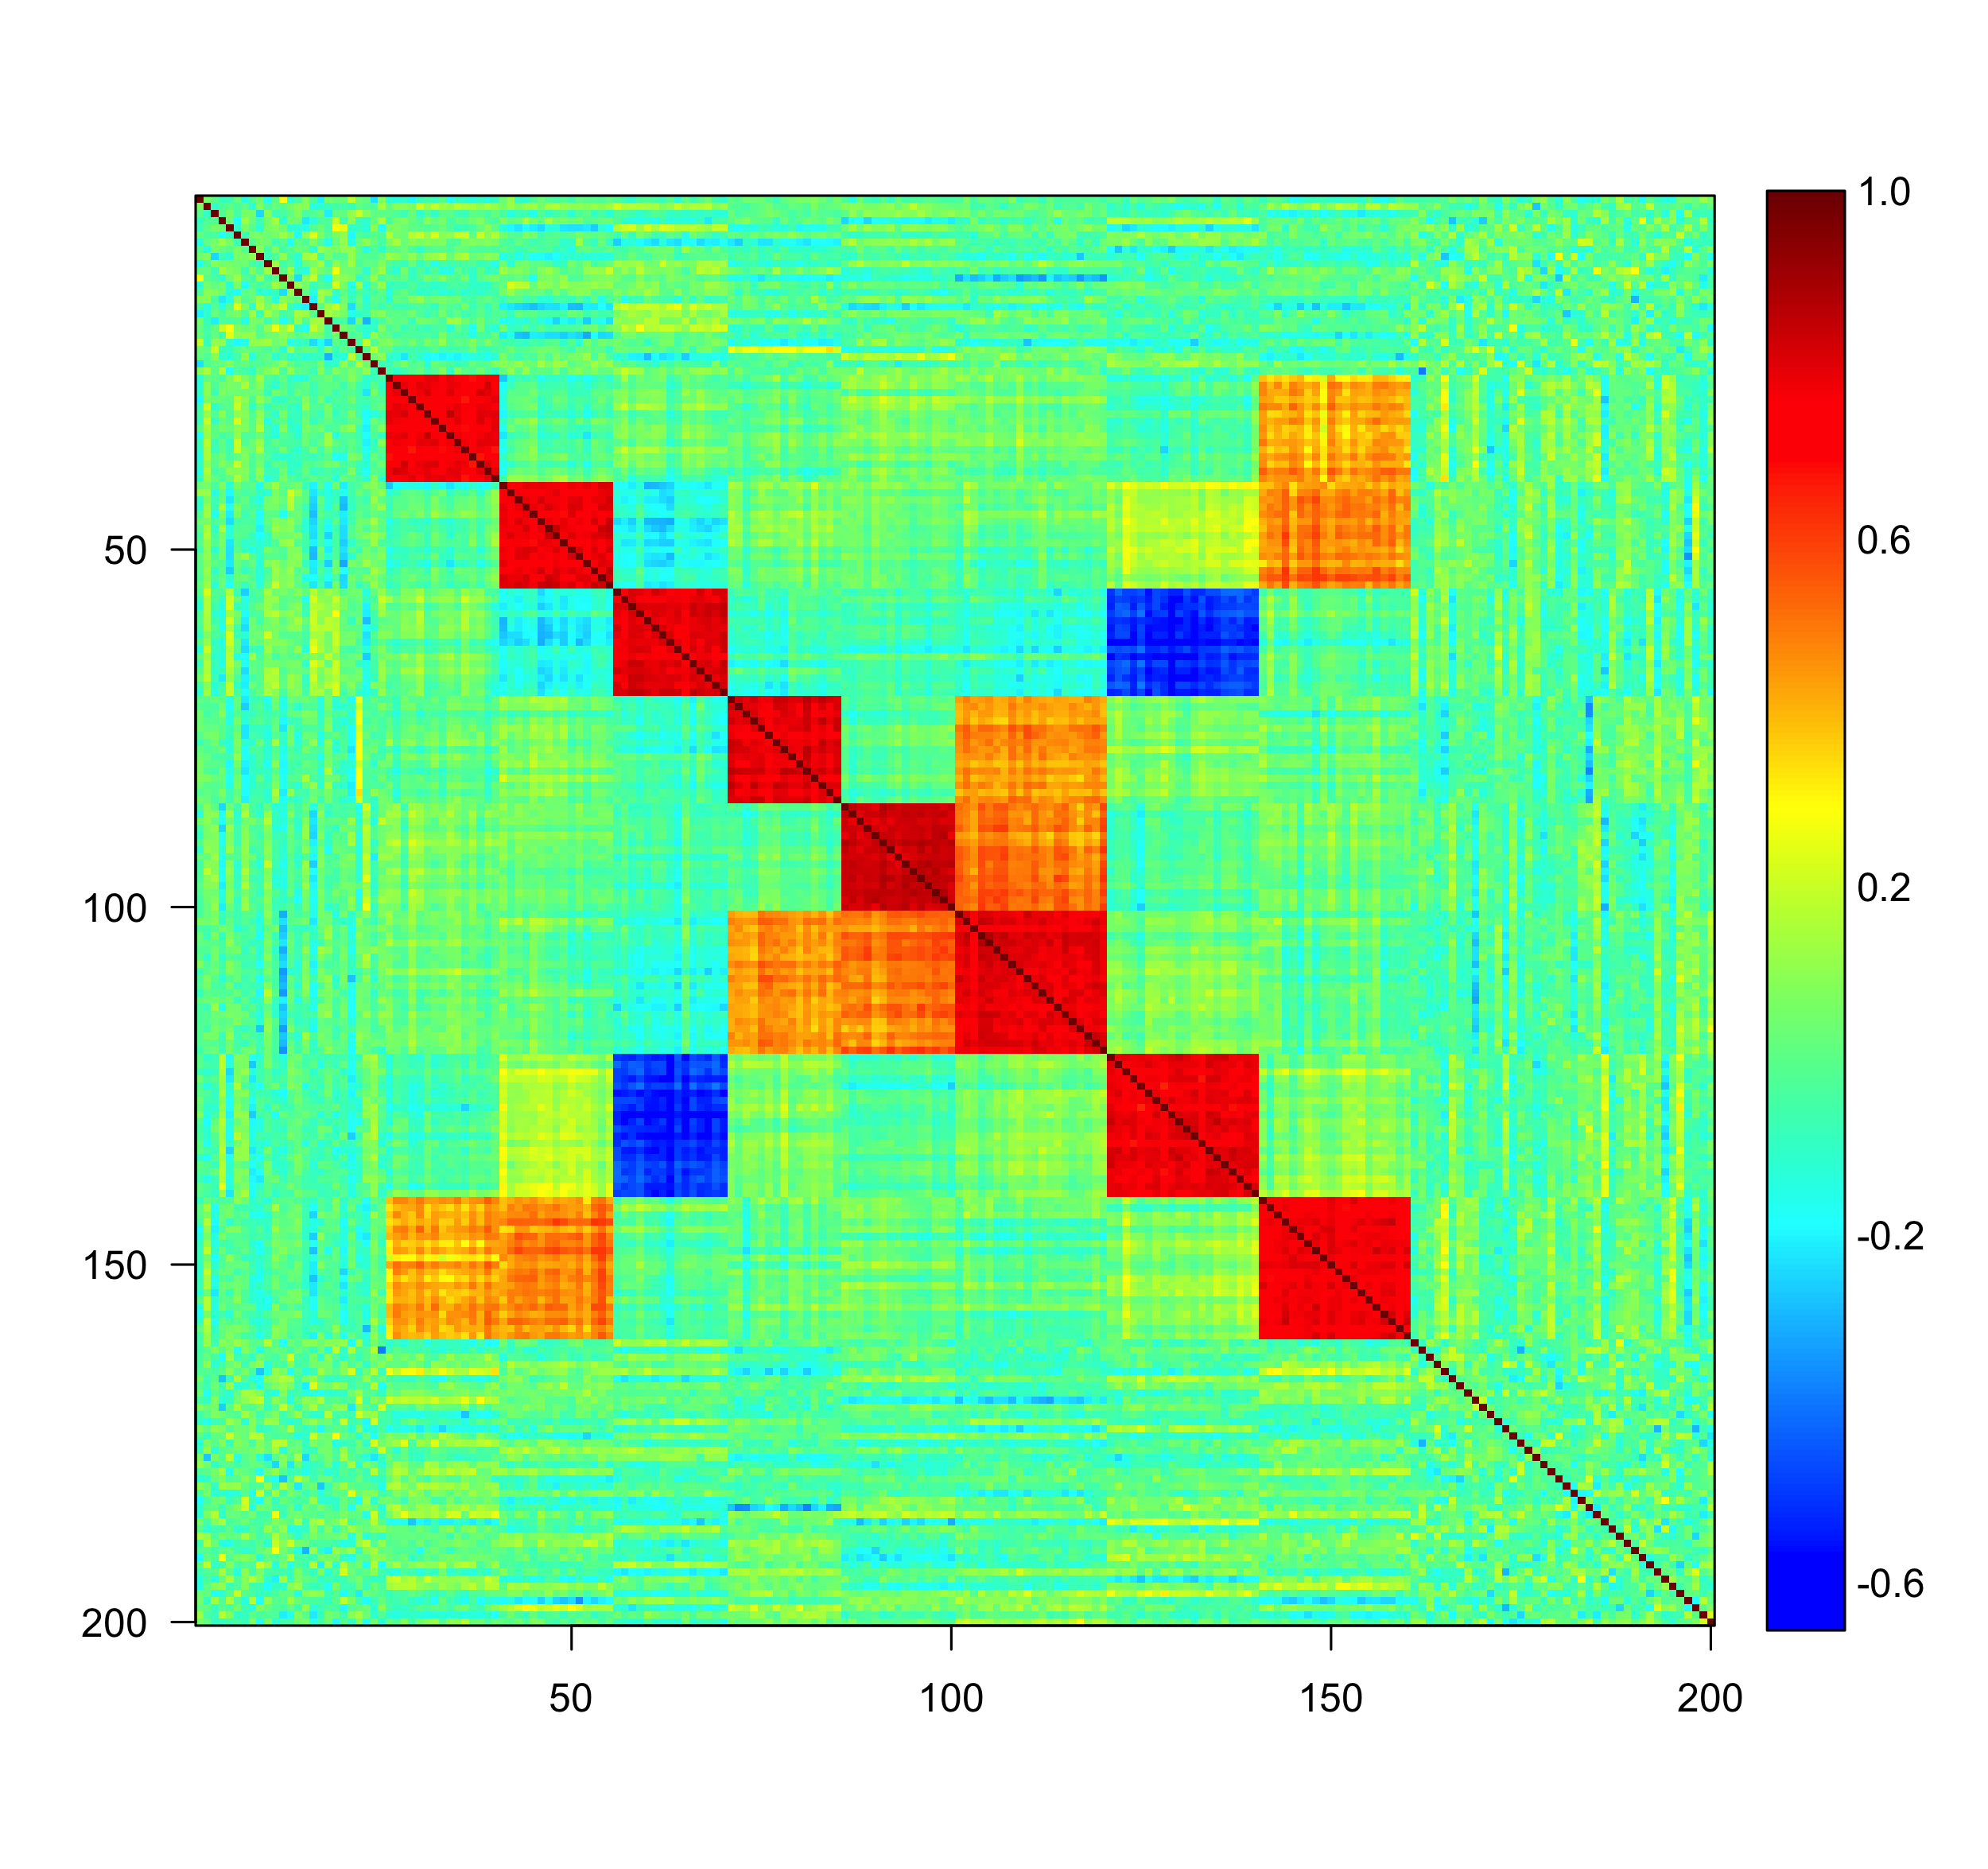

## [**ICONS**](https://github.com/xavienzo/ICONS)
*   Integrative analysis of COvariance matrix and Network Structure
*   A novel adaptive subnetwork extraction tool

Reference
- Wu, Q. et al. Extracting brain disease-related connectome subgraphs by adaptive dense subgraph discovery. Biometrics 78, 1566–1578 (2021).
- Chen, S. et al. Identifying covariate-related subnetworks for whole-brain connectome analysis. Biostatistics 25, 541–558 (2024).


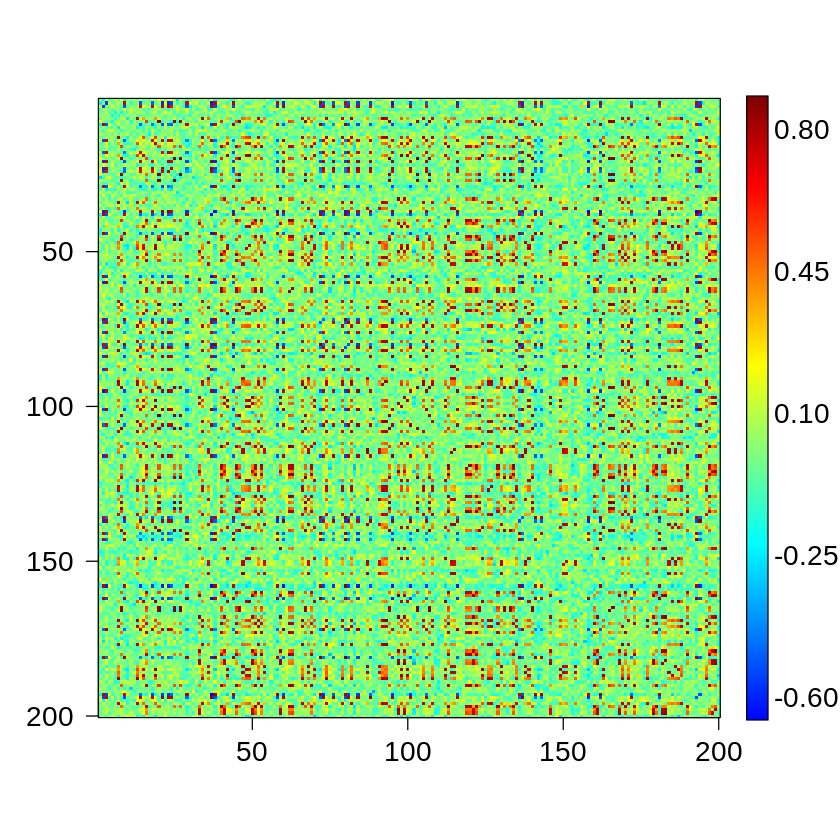

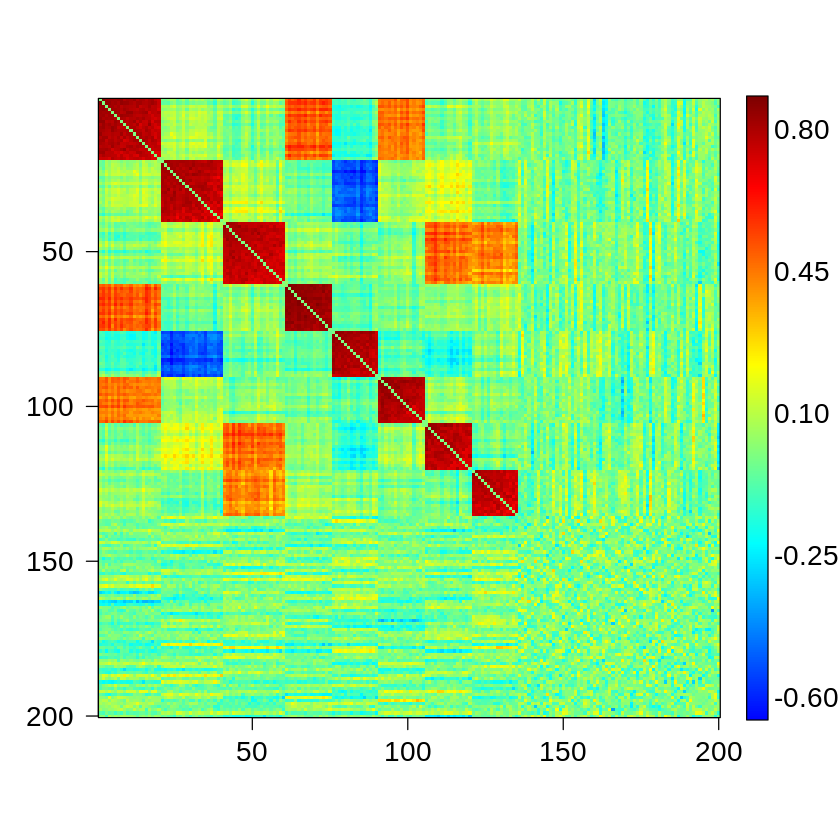

In [2]:
data(sim)
matrix <- cor(sim)

# specify a vector of cutout thresholds and a vector of lambdas for grid search
prctile_vec <- seq(94, 99, by = 0.5)
lam_vec <- seq(0.4, 0.8, length.out = 5)

# grid search
param <- param_tuning_sigmau(matrix, sim, prctile_vec, lam_vec)

# use optimal parameters to extract subnetworks
results <- dense(W_original = matrix, threshold = param$cut_out, lambda = param$lambda_out)


# Plot original correlation matrix
# Uncomment the lines to save figures; more plotting options available
matrix_wodiag <- matrix - diag(diag(matrix))
plotMatrix(matrix_wodiag,
           # save.image = T,
           # filepath = "figure/simulation_orig.png",
           # format = "png",
           cex.axis = 1.4, cex.lab = 1.4)

# Plot the reordered correlation matrix showing network structures
plotMatrix(results$W_dense,
           # save.image = T,
           # filepath = "figure/simulation_dense.png",
           # format = "png",
           cex.axis = 1.4, cex.lab = 1.4)


In [3]:
get_sigmau(sim, results$CID, results$Clist)[[2]]

[1] 16.29318

## [**LOUVAIN**](https://doi.org/10.1088/1742-5468/2008/10/P10008)
Blondel, V. D., Guillaume, J.-L., Lambiotte, R. & Lefebvre, E. Fast unfolding of communities in large networks. J. Stat. Mech. Theory Exp. 10008, 6 (2008).


In [47]:
cor_matrix <- abs(matrix)
G <- graph_from_adjacency_matrix(cor_matrix,
                                 weighted = T,
                                 mode = "undirected")
louvain_result <- cluster_louvain(G)

communities <- louvain_result$membership

In [48]:
CID_l <- as.numeric(table(factor(communities, levels = sort(unique(communities)))))
Clist_l <- order(communities)
nullidx <- get_index(1, CID_l, Clist_l)[[1]]
valididx <- get_index(2:4, CID_l, Clist_l)[[1]]
CID_l <- CID_l[c(2:4,1)]
Clist_l <- c(valididx, nullidx)
get_sigmau(sim, CID_l, Clist_l)[[2]]

[1] 35.55552

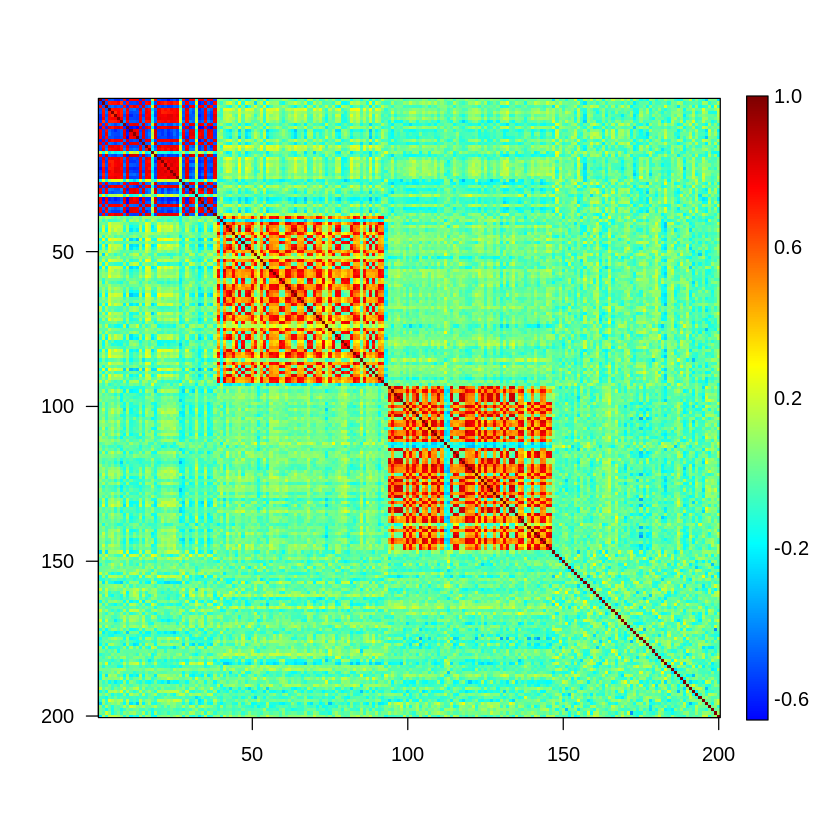

In [49]:
cor_louvain <- matrix[Clist_l, Clist_l]
plotMatrix(cor_louvain)

## [**Greedy peeling**](https://doi.org/10.1088/1742-5468/2008/10/P10008)
Clauset, A., Newman, M. E. J. & Moore, C. Finding community structure in very large networks. Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 70, (2004).

In [50]:
greedy_result <- cluster_fast_greedy(G)
communities <- greedy_result$membership

In [51]:
CID_g <- as.numeric(table(factor(communities, levels = sort(unique(communities)))))
Clist_g <- order(communities)
nullidx <- get_index(1, CID_g, Clist_g)[[1]]
valididx <- get_index(2:4, CID_g, Clist_g)[[1]]
CID_g <- CID_g[c(2:4,1)]
Clist_g <- c(valididx, nullidx)
get_sigmau(sim, CID_g, Clist_g)[[2]]

[1] 35.92709

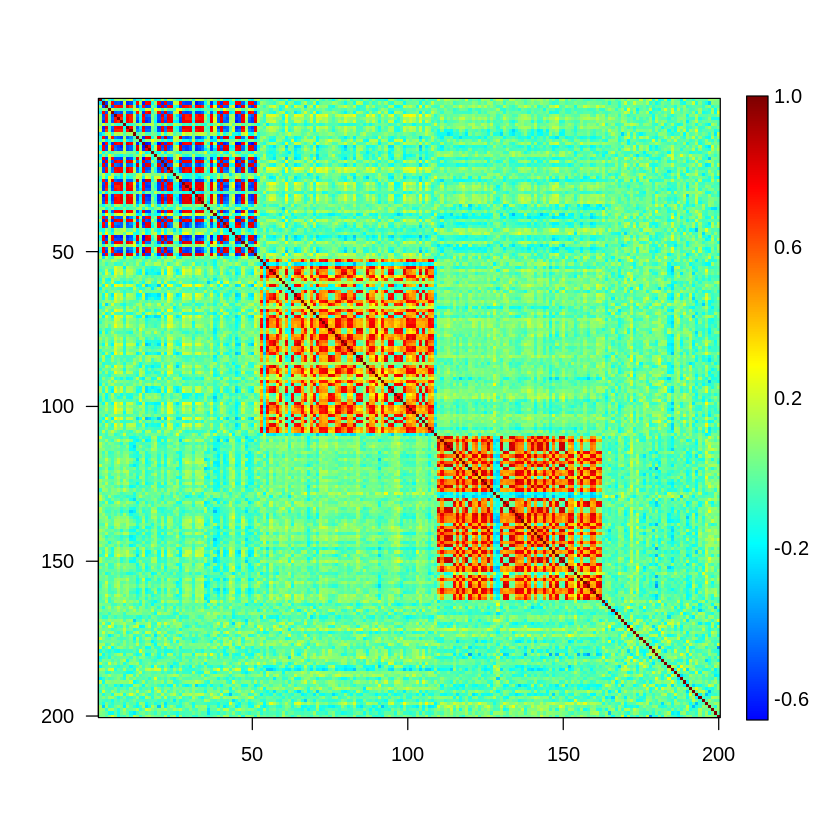

In [52]:
cor_greedy <- matrix[Clist_g, Clist_g]
plotMatrix(cor_greedy)